<font size=3>&nbsp; &nbsp;To show the implementation process of the TNMP algorithm, we focus on a specific model - a spin glass model (with $J \sim Bernoulli(0.5) \times 2 - 1$ and $h \sim N(0,\frac{\pi}{200})$ ) on the “494 bus power system” with the energy function $E(\mathbf{s}) = -\sum_{(ij)\in \mathcal{E}} J_{ij}s_is_j - \sum_{i}h_is_i$, where the binary variable $\mathbf{s}$ satisfies Boltzmann distribution. The work flow of TNMP is showed below based on the example.

In [1]:
import sys
import networkx as nx
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
from copy import deepcopy
from IPython import display
sys.path.append("./include")
from read_model import read_model
from plot import neighborhood_show,cavity_show,tensor_network_show,process_animation_show,get_layer_environment_node
from local_subgraph_generator import Ni_generator,neighborhood_grow,cavity_subgraph_generator
from local_tensor_network_contraction import local_contraction
np.set_printoptions(threshold=sys.maxsize)
np.set_printoptions(threshold=sys.maxsize,precision=20)
G,J,h = read_model("494bus_G","494bus_J_random","494bus_h_random")

<font size=5>Mapping model graph G to tensor networks</font> <br>

<font size=3>&nbsp; &nbsp;In statistical mechanics problems defined on a graph $G$, any physical quantity that can be expressed as the sum of the Boltzmann distribution in the state space $\left\{+1,-1\right\} ^n$ or its sub-space tracing only part of the spins, can correspond to a tensor network $T$. Every vertex in $G$ corresponds to a rank-one tensor which is equivalent to a copy tensor with a field vector connected to it, every edge in $G$ corresponds to a Boltzmann matrix in $T$ and two tensors share a common leg if their correspondences in $G$ are neighboring elements. <br>

<font size=3> &nbsp; &nbsp; Since the graph of the 494-bus-power-system is too large to show, we just visualize the corresponding tensor network of a toy model here. In the figure of $G_{toy}$, the black lines repredent the edges of $G_{toy}$ and the orange dots represent the vertices of  $G_{toy}$. In the corresponding tensor network figure, the green squares represent the Boltzmann matrices, the orange hexagons represent the field vectors, the black lines represent the outer leg of the tensors and their intersections represent bonds, where the red bond represents the open leg of the result tensor.

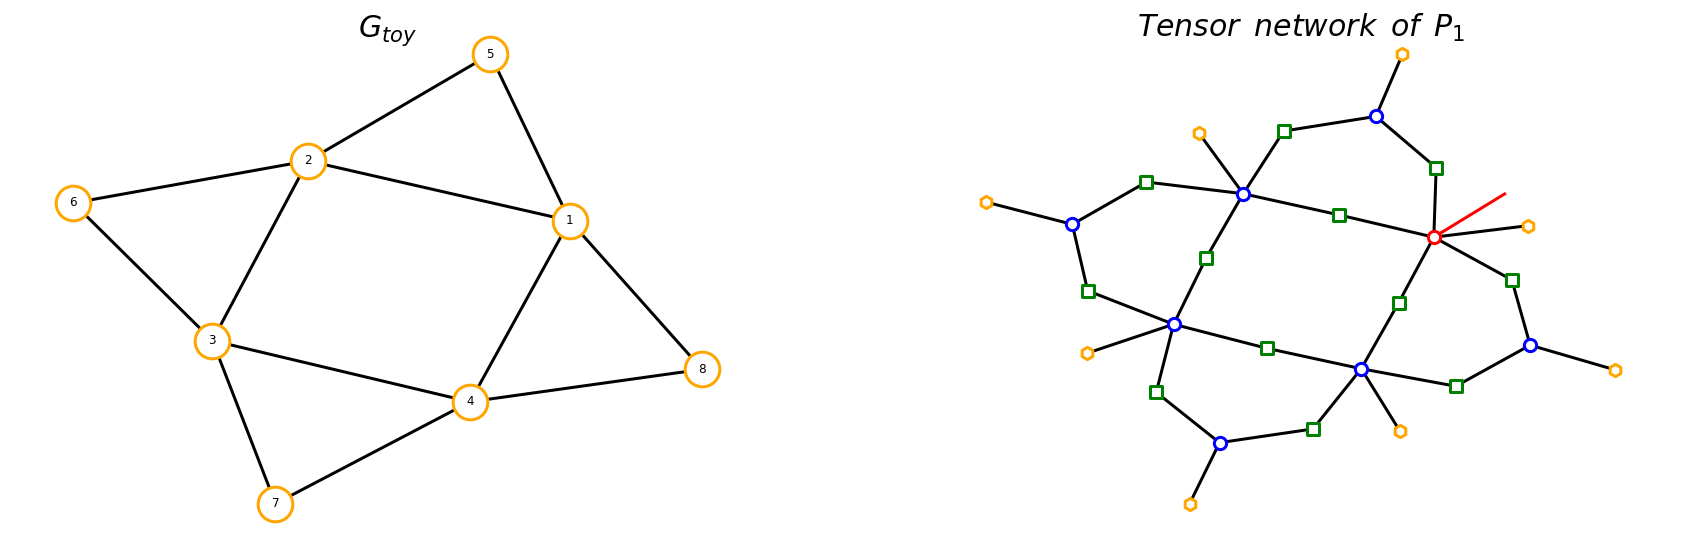

In [2]:
G_toy = nx.Graph()
edges = [(1,2),(1,4),(1,5),(1,8),(2,5),(2,6),(2,3),(3,4),(3,6),(3,7),(4,7),(4,8)]
G_toy.add_edges_from(edges)
fig, axs = plt.subplots(1, 2,figsize=(30,10))
position_T = tensor_network_show(G_toy, G_toy, G_toy, 1, r'$Tensor\enspace network\enspace of\enspace {P_1}$', axs[1])
axs[1].set_frame_on(False)
nx.draw(G_toy,pos=position_T,with_labels=True,node_color ='w', edgecolors='orange',width=3,linewidths=3,node_size=1200,ax=axs[0])
axs[0].set_title(r"$G_{toy}$", fontsize=30,pad=-30)
plt.show()

<font size=5>Neighborhood Generating</font> <br>
<font size=3>

&nbsp; &nbsp;We get the corresponding graph of the neighborhood $\mathcal{N}_i$ of each vertex $i$, which contains edges and vertices around $i$ satisfying that the minimum distance between all pairs of vertices on the boundary $\partial G_{\mathcal{N}_i}$  in the complement of $G_{\mathcal{N}_i}$ not smaller than a given value $R$.  <br>
* To generate such a $G_{\mathcal{N}_i}(R)$, we firstly get $G_{\mathcal{N}_i}(R=0)$, which is just the direct neighbors of $i$ and the edges including $i$. Then we can generate $G_{\mathcal{N}_i}(R=1)$ by adding the edges shared by any two direct neighbors of $i$. <br>

&nbsp; &nbsp;To provide a clearer presentation, we only focus on part of the whole $G$ near the center node. You can control the local range of our focus by adjusting the parameter $\textit{focus\_ layer}$ and the larger focus_layer, the larger the drawn part. In the figure of $G$, the colored nodes and edges constitute $G_{\mathcal{N}_i}(R)$, where the orange elements represent newly added nodes and edges to $G_{\mathcal{N}_i}(R-1)$ or to the previous turn. Among the nodes, the dots indicate the nodes inside $G_{\mathcal{N}_i}(R)$, whereas the hexagons represent the nodes on the boundary. In the figure of tensor networks, the shapes of the marks are the same as the previous section while the purple diamonds that have not appeared in the global tensor network figure represent message vectors. The colored part corresponds to $\mathcal{N}_i(R)$ and the gray part corresponds to the environment. To further distinguish the boundary, boundary nodes appear pink while internal nodes appear blue respectively.

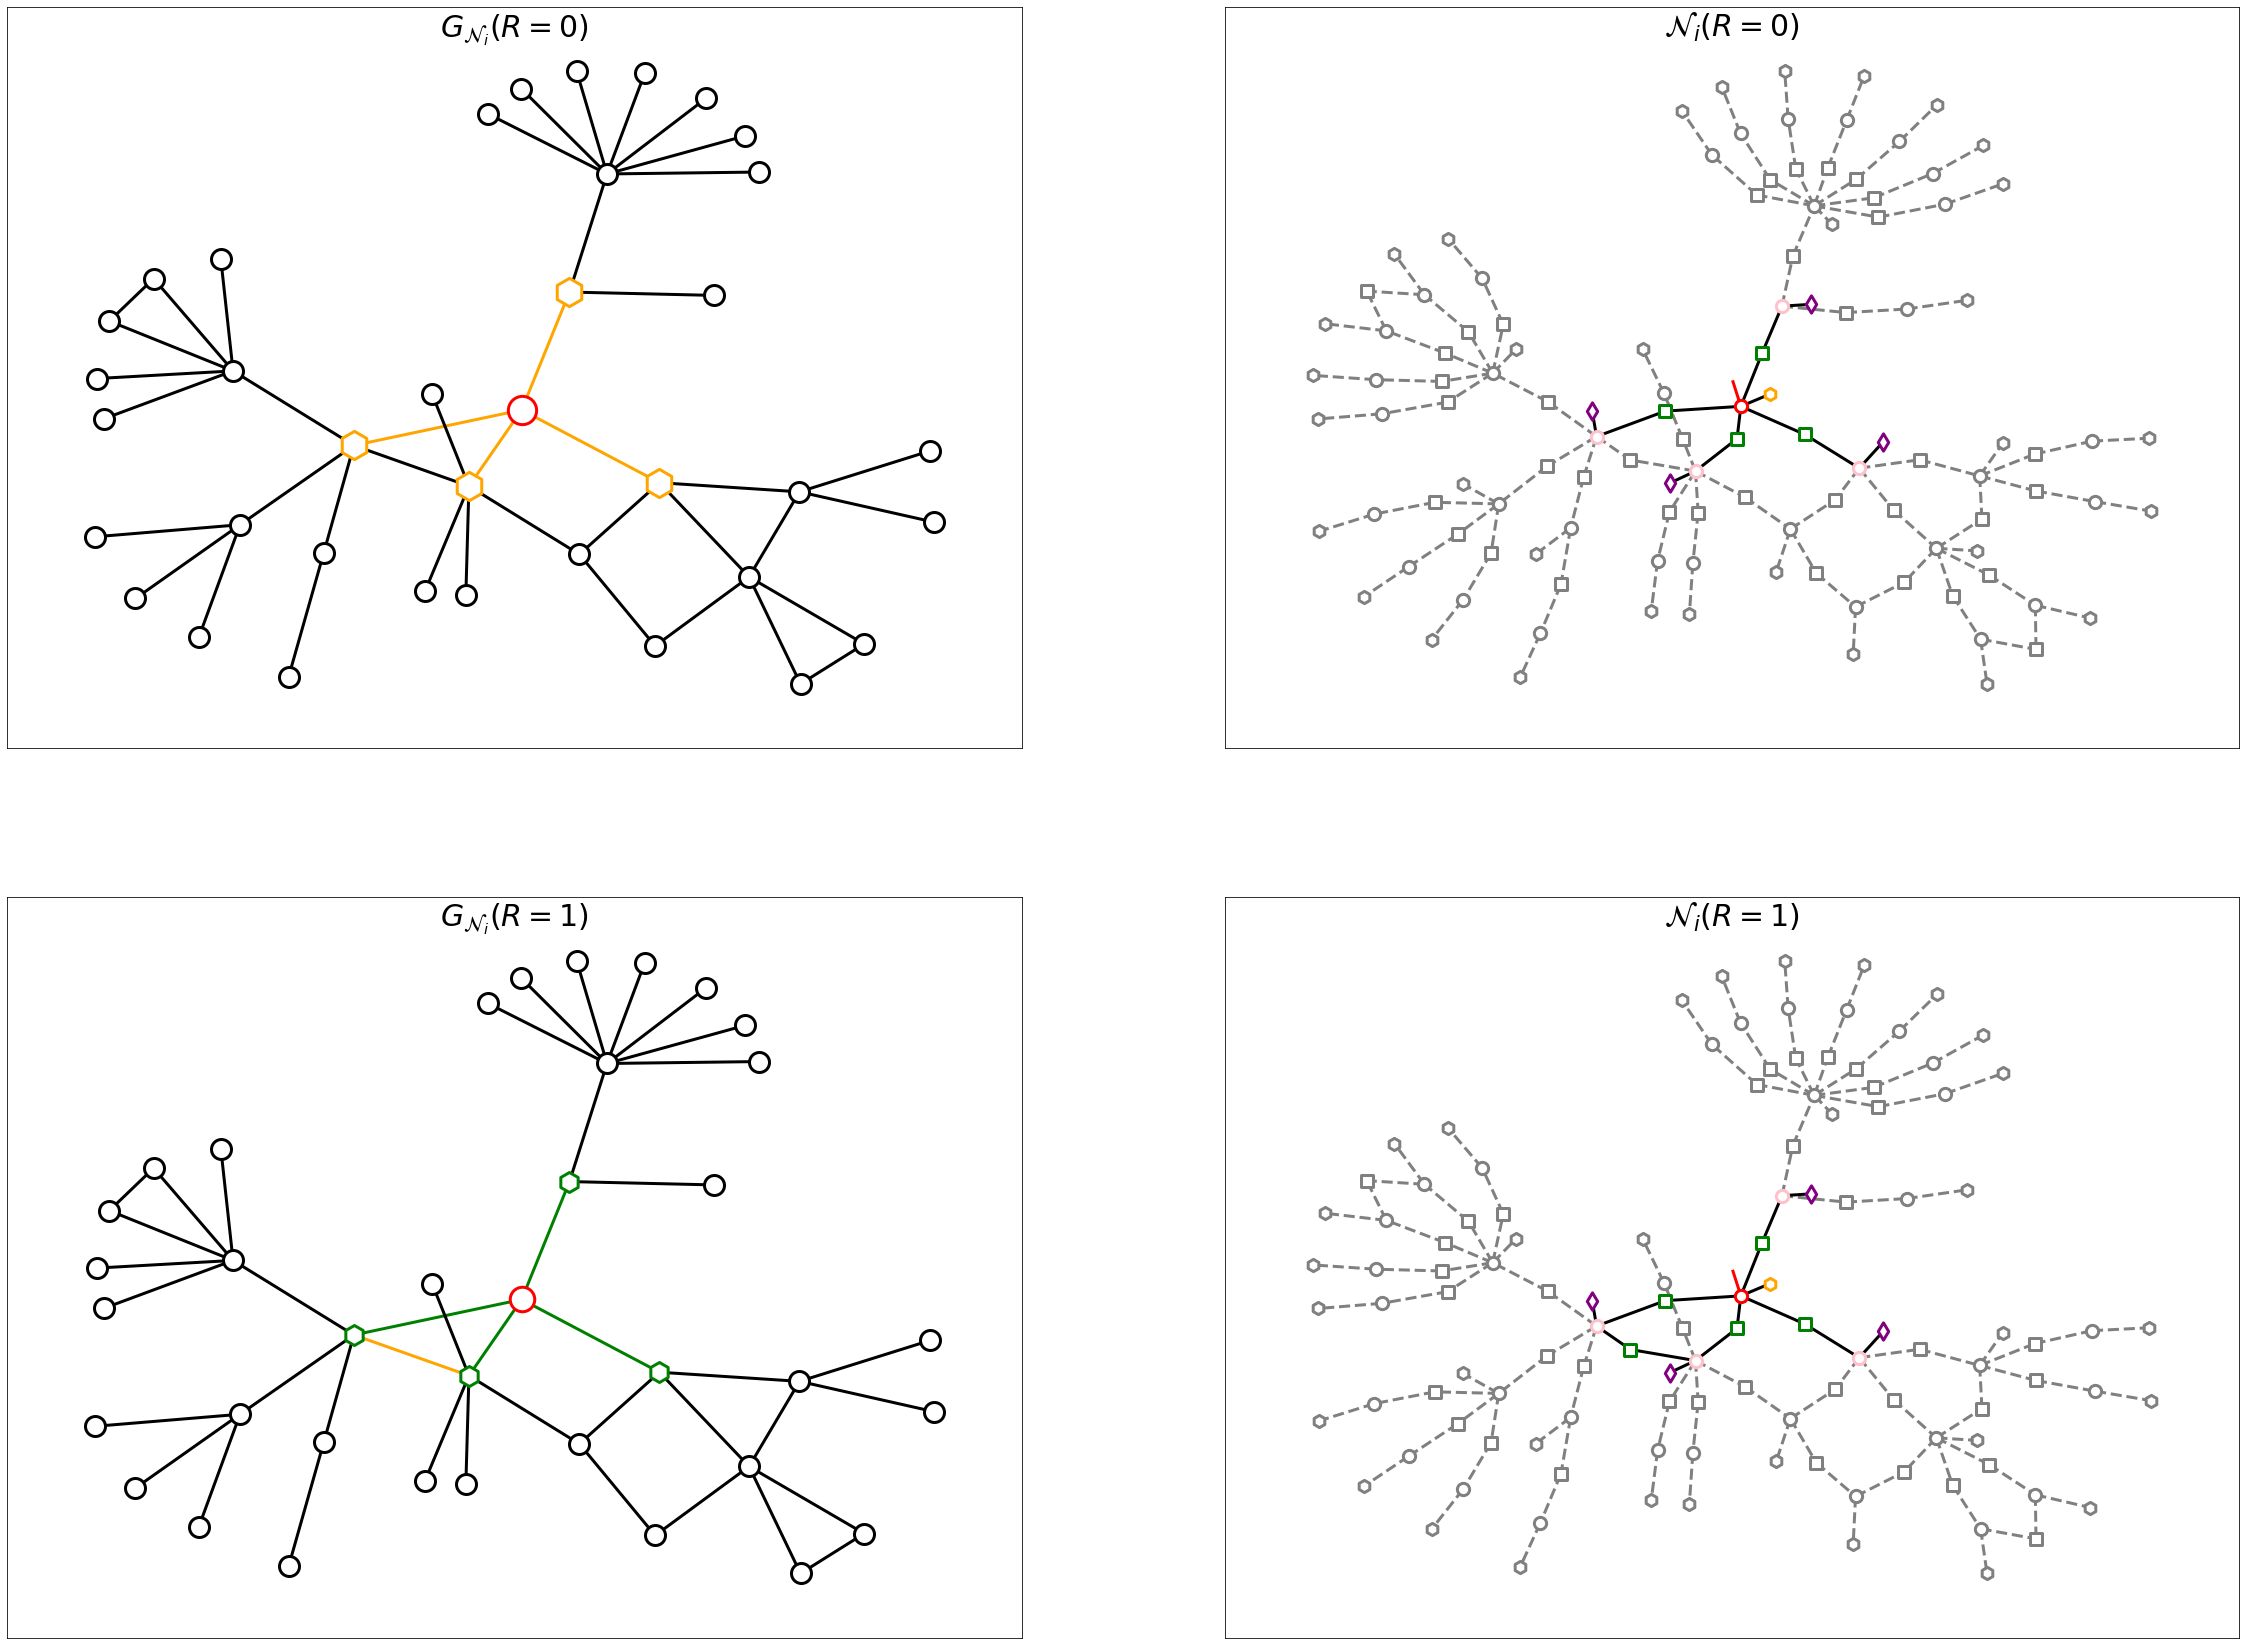

In [3]:
center_node = 241
focus_layer = 3
G_neighborhood = nx.Graph()
G_environment = deepcopy(G)
fig, axs = plt.subplots(2, 2,figsize=(40,30))
Ni_v = []
Ni_e = []
for direct_neighbor_of_i in G.neighbors(center_node):
    Ni_v.append(direct_neighbor_of_i)
    Ni_e.append((center_node,direct_neighbor_of_i))
G_neighborhood.add_nodes_from(Ni_v)
G_neighborhood.add_edges_from(Ni_e)
G_environment.remove_edges_from(Ni_e)
G_focus = get_layer_environment_node(G, focus_layer, center_node)
position_T = tensor_network_show(G_neighborhood, G, G_focus, center_node, r'$\mathcal{N}_{i}(R=0)$', axs[0,1])
neighborhood_show(G_neighborhood,G_focus,center_node,list(G_neighborhood.nodes()),Ni_e,Ni_v,r"$G_{\mathcal{N}_i}(R=0)$",position_T,axs[0,0])
new_edges = []
for node in Ni_v:
    for noden in G.neighbors(node):
        if noden in Ni_v and (node,noden) not in Ni_e and (noden,node) not in Ni_e:
            G_neighborhood.add_edge(node,noden)
            G_environment.remove_edge(node,noden)
            Ni_e.append((node,noden))
            new_edges.append((node,noden))
tensor_network_show(G_neighborhood, G, G_focus, center_node, r'$\mathcal{N}_{i}(R=1)$', axs[1,1])
neighborhood_show(G_neighborhood,G_focus,center_node,[],new_edges,Ni_v,r"$G_{\mathcal{N}_i}(R=1)$",position_T,axs[1,0])
plt.show()



* <font size=3>Based on $G_{\mathcal{N}_i}(R=r-1)$, we generate $G_{\mathcal{N}_i}(R=r)$ by iterating: <br>
    - Find the boundary of the neighborhood, which refers to the vertices connected to edges outside the neighborhood.<br>
    - For all the pairs on the boundary, find all the paths between them in $G_{\text{environment}}=G \backslash G_{\mathcal{N}}$ with length smaller than $R$, then add the vertices and edges on the path into the neighborhoood.  <br> 

   <font size=3>-till we get a $G_{\mathcal{N}_i}(R)$ with a boundary satisfying that the minimum distance between all the pairs on $\partial G_{\mathcal{N}_i}$  in $G_{\text{environment}}$ not smaller than $R$. <br>
   So with $G_{\mathcal{N}_i}(R=0)$ and $G_{\mathcal{N}_i}(R=1)$ above, we can generate $G_{\mathcal{N}_i}(R=2)$ and $G_{\mathcal{N}_i}(R=3)$ and so on.

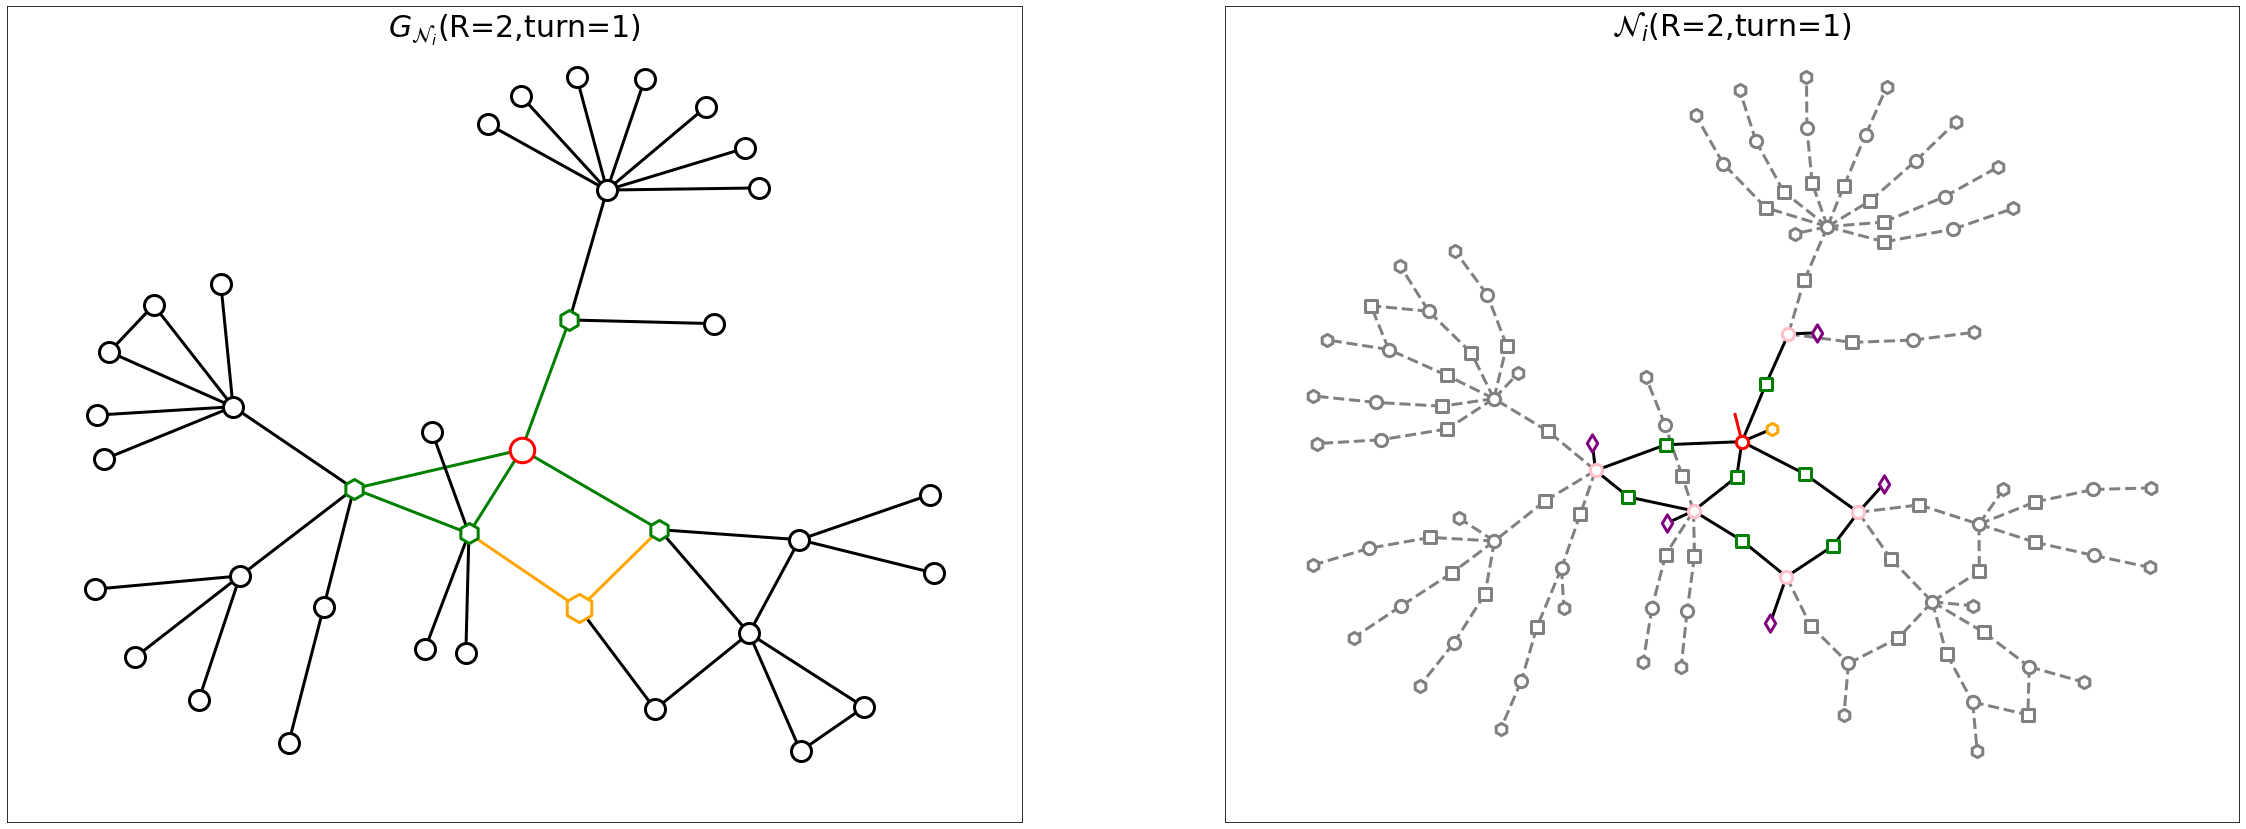

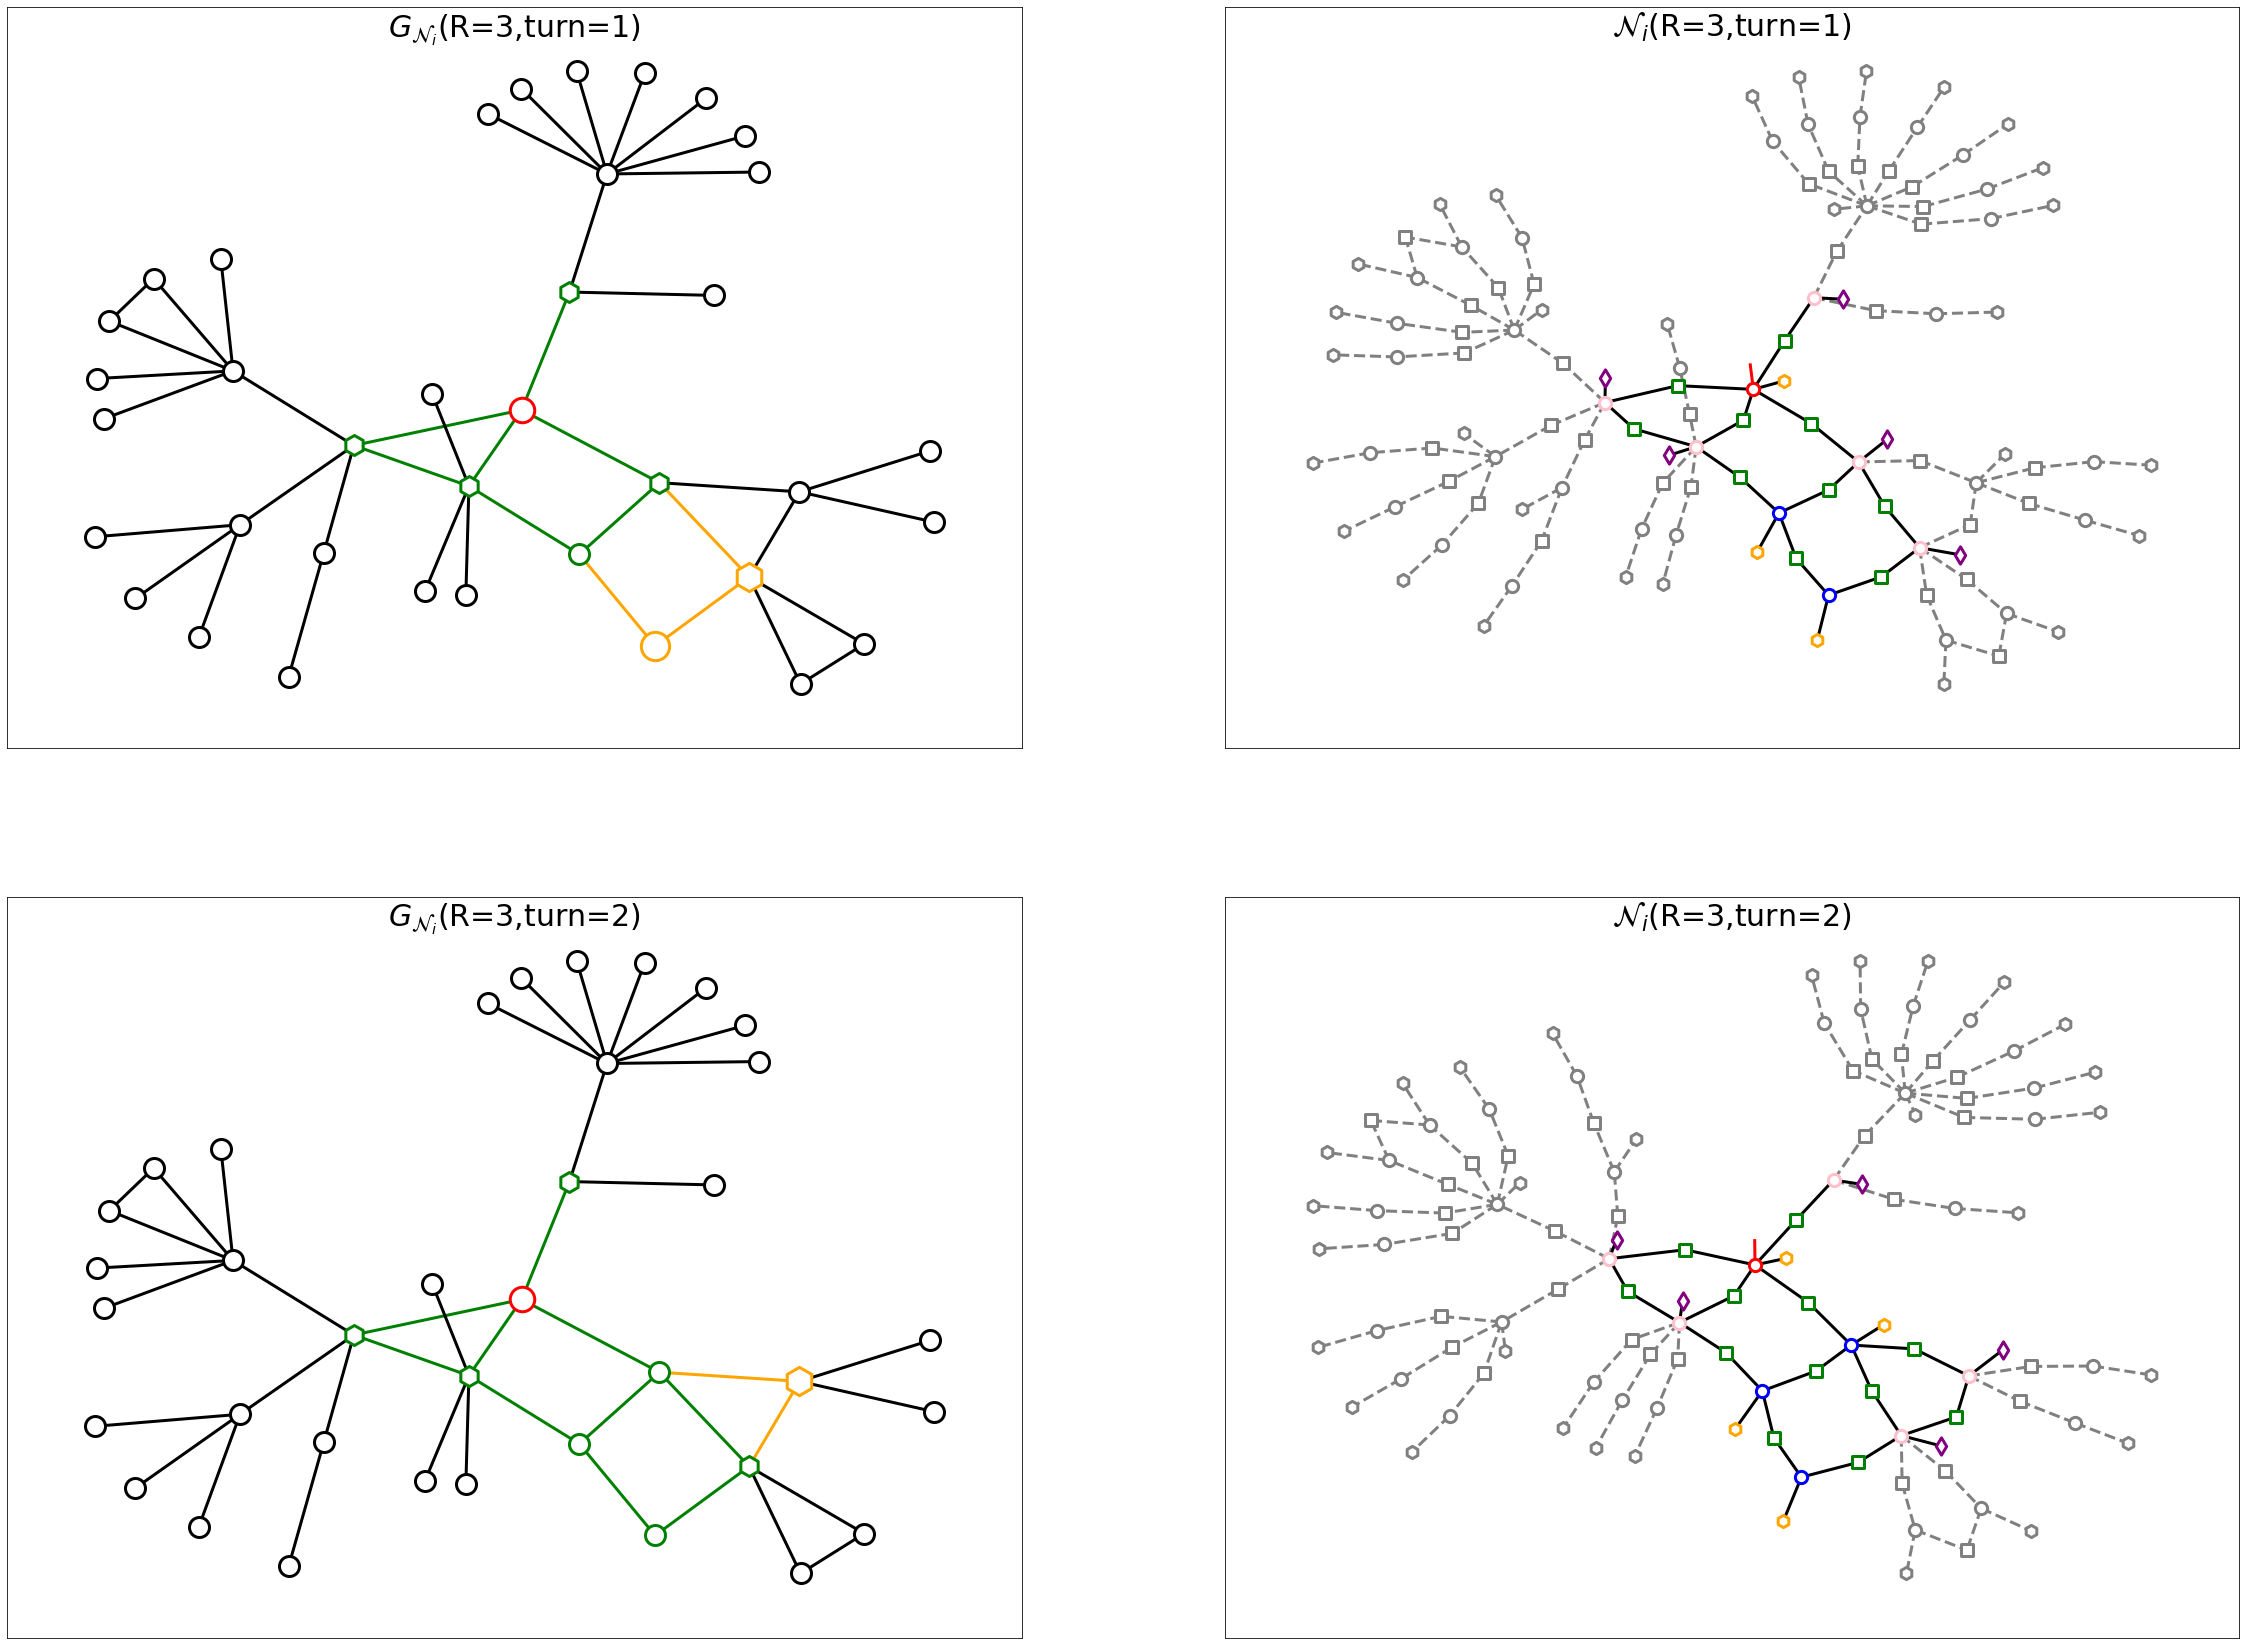

In [4]:
Rs = [2,3]
for R in Rs:
    G_neighborhoods,new_nodes,new_edges,boundaries,G_environment,turn = neighborhood_grow(G,G_neighborhood,G_environment,R)
    G_neighborhood = G_neighborhoods[-1]
    fig, axs = plt.subplots(turn-1,2,figsize=(40,15*(turn-1)))
    for turn_id in range(turn-1): 
        if turn == 2:
            tensor_network_show(G_neighborhoods[turn_id], G, G_focus, center_node, r'$\mathcal{N}_{i}$'+ '(R={},'.format(R) + 'turn={})'.format(turn_id+1), axs[1])
            neighborhood_show(G_neighborhoods[turn_id],G_focus,center_node,new_nodes[turn_id],new_edges[turn_id],boundaries[turn_id],r"$G_{\mathcal{N}_i}$" + '(R={},'.format(R) + 'turn={})'.format(turn_id+1),position_T,axs[0])
        else:            
            tensor_network_show(G_neighborhoods[turn_id], G, G_focus, center_node, r'$\mathcal{N}_{i}$'+ '(R={},'.format(R) + 'turn={})'.format(turn_id+1), axs[turn_id,1])
            neighborhood_show(G_neighborhoods[turn_id],G_focus,center_node,new_nodes[turn_id],new_edges[turn_id],boundaries[turn_id],r"$G_{\mathcal{N}_i}$" + '(R={},'.format(R) + 'turn={})'.format(turn_id+1),position_T,axs[turn_id,0])
    plt.show()

<font size=3> Without losing generality, we fix R=3 and as shown above, we generate $\mathcal{N}_i(3)$ for all the vertices $i$:

In [5]:
R = 3
Nv = []
Ne = []
size_of_neighborhood = []
boundaries = []
for i in range(G.number_of_nodes()):
    Ni_v,Ni_e = Ni_generator(G,i,R)
    Nv.append(Ni_v)
    Ne.append(Ni_e)
    size_of_neighborhood.append(len(Ni_v))
    boundary = []
    for node in Ni_v:
        for noden in G.neighbors(node):
            if (node,noden) not in Ni_e and (noden,node) not in Ni_e:
                boundary.append(node)
                break
    boundaries.append(boundary)
print("The max size of neighborhoods of R={} is:".format(R),max(size_of_neighborhood))
print("The mean size of neighborhoods of R={} is:".format(R),sum(size_of_neighborhood)/len(size_of_neighborhood))  

The max size of neighborhoods of R=3 is: 18
The mean size of neighborhoods of R=3 is: 3.9959514170040484


<font size=5>Cavity Sub-graph Generating</font> <br><br>

<font size=3>&nbsp; &nbsp;Now with the neighborhoods, we can get the sub tensor network to be contracted in the cavity tensor calculation, which corresponds to the edge induced graph from $E(G_{\mathcal{N}_a}) \backslash E(G_{\mathcal{N}_i})$ for $m_{a \rightarrow \mathcal{N}_i}$.

<font size=3>&nbsp; &nbsp;As in the previous section, the colored parts in the figure represent the subgraphs or sub-networks in the title. In the tensor network figure, the markings are the same as in the previous section, while in the graph figure, the red dot represents the center node $i$ whose marginal $P_i$ is desired and the blue dot represents the boundary node $a$ which is on the boundary of $G_{\mathcal{N}_i}$.


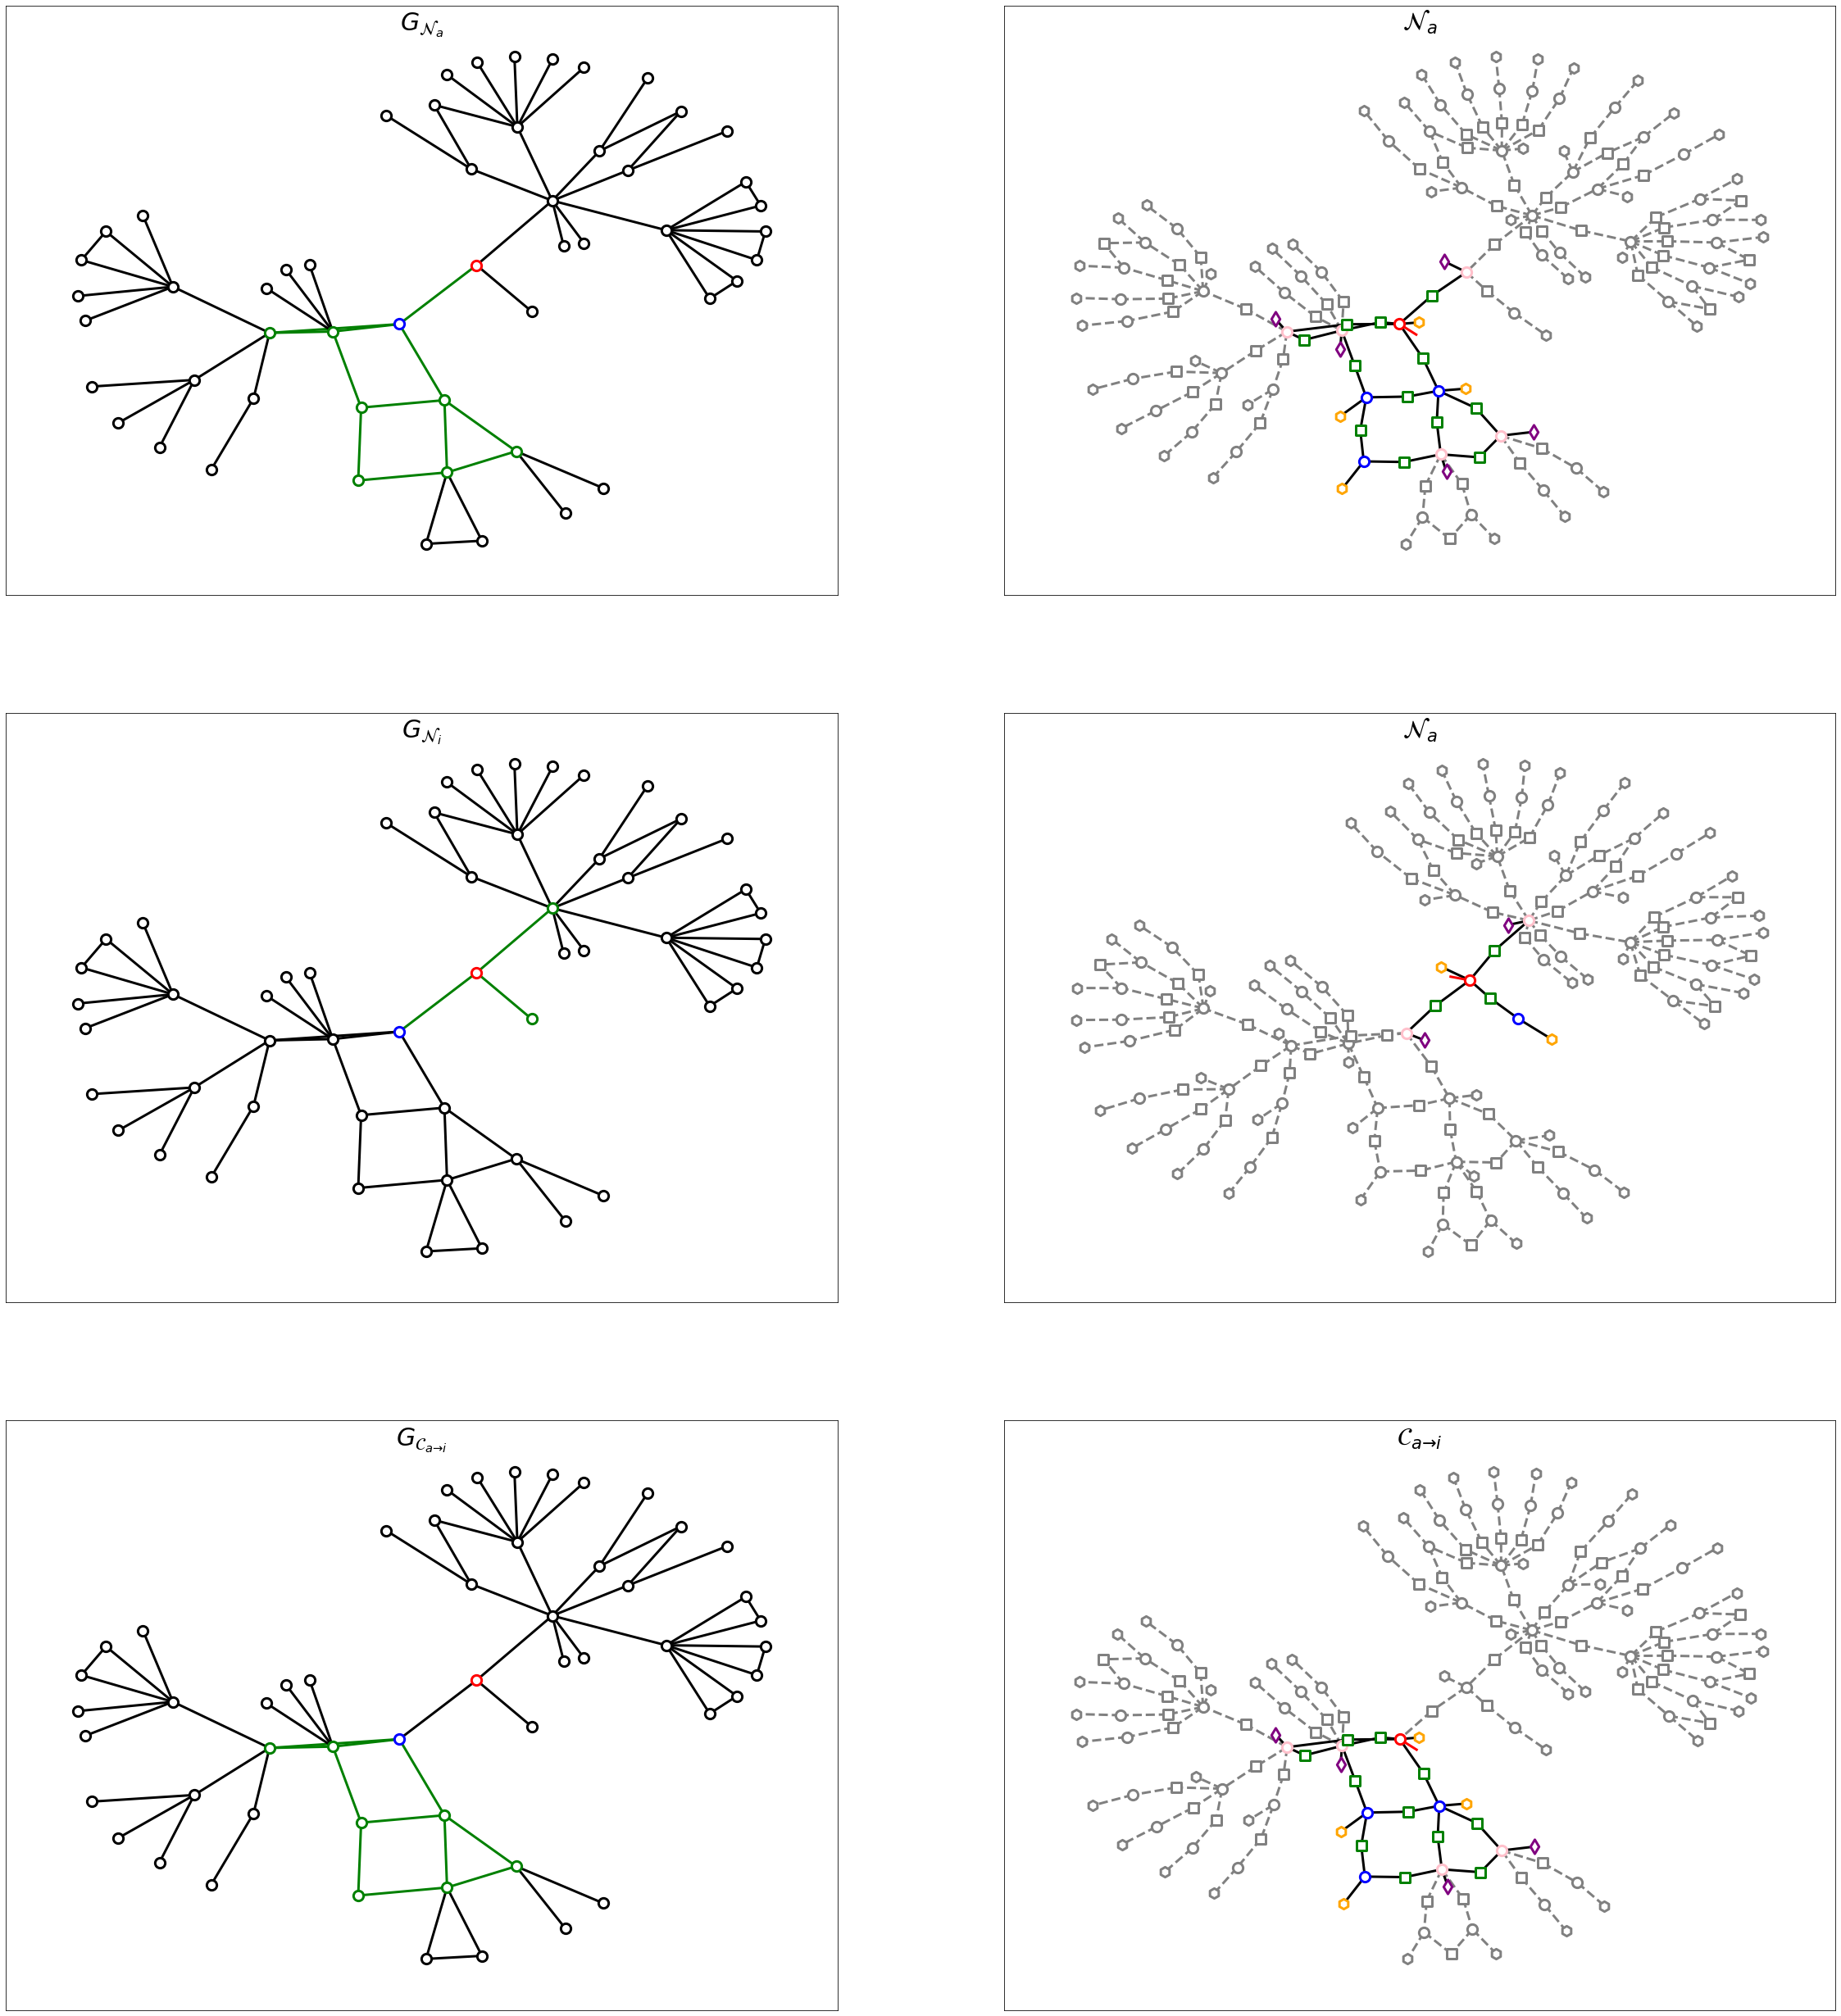

In [6]:
a = 241
i = 142
G_neighborhood_a = nx.Graph()
G_neighborhood_i = nx.Graph()
G_cavity = nx.Graph()
G_neighborhood_a.add_edges_from(Ne[a])
G_neighborhood_i.add_edges_from(Ne[i])
Nc_e = []
for node1,node2 in Ne[a]:
    if not G_neighborhood_i.has_edge(node1,node2):
        Nc_e.append((node1,node2))
G_cavity.add_edges_from(Nc_e)
fig, axs = plt.subplots(3,2,figsize=(40,45))
G1 = get_layer_environment_node(G, focus_layer, i)
G2 = get_layer_environment_node(G, focus_layer, a)
G_focus = nx.compose(G1,G2)
position_T = tensor_network_show(G_neighborhood_a, G, G_focus, a, r'$\mathcal{N}_{a}$', axs[0,1])
cavity_show(G_neighborhood_a,G_focus,a,i,r"$G_{\mathcal{N}_{a}}$",position_T,axs[0,0])
tensor_network_show(G_neighborhood_i, G, G_focus, i, r'$\mathcal{N}_{a}$', axs[1,1])
cavity_show(G_neighborhood_i,G_focus,a,i,r"$G_{\mathcal{N}_{i}}$",position_T,axs[1,0])
tensor_network_show(G_cavity, G, G_focus, a, r"$\mathcal{C}_{a \to i}$", axs[2,1])
cavity_show(G_cavity,G_focus,a,i,r"$G_{\mathcal{C}_{a \to i}}$",position_T,axs[2,0])


<font size=5>Tensor Network Message Passing</font> <br> <br>
<font size=3>&nbsp; &nbsp;In TNMP, with the message vectors from the last iteration step $\vec{m}(t-1)$, we contract the local tensor network $\mathcal{C}_{a \to i}$ to get the new message vector $m_{a \to i}(t)$. Then with the message vectors that have converged through iterations, we contract the local tensor network $\mathcal{N}_{i}$ to get the marginal $P_i$ of each vertex $i$. <br>
<font size=3>&nbsp; &nbsp;In each iteration turn, based on the local tensor network contraction, we successively  get the message vector $m_{a \to i}(t)$ for every boundary-center pair ($a,i$) using the message vectors on the boundary of $G_{\mathcal{N}_a}$ from the (t-1)-th turn. A visual process of one of the calculations of $m_{a \to i}(t)$ is shown below, where the red dot represents $i$ and the blue dot represents $a$. In the animation, the last diamond that appears represents $m_{a \to i}(t)$, while all other previously appearing colored diamonds represent $m_{k \to a}(t-1)$ for k on the boundary of $G_{\mathcal{N}_a}$.

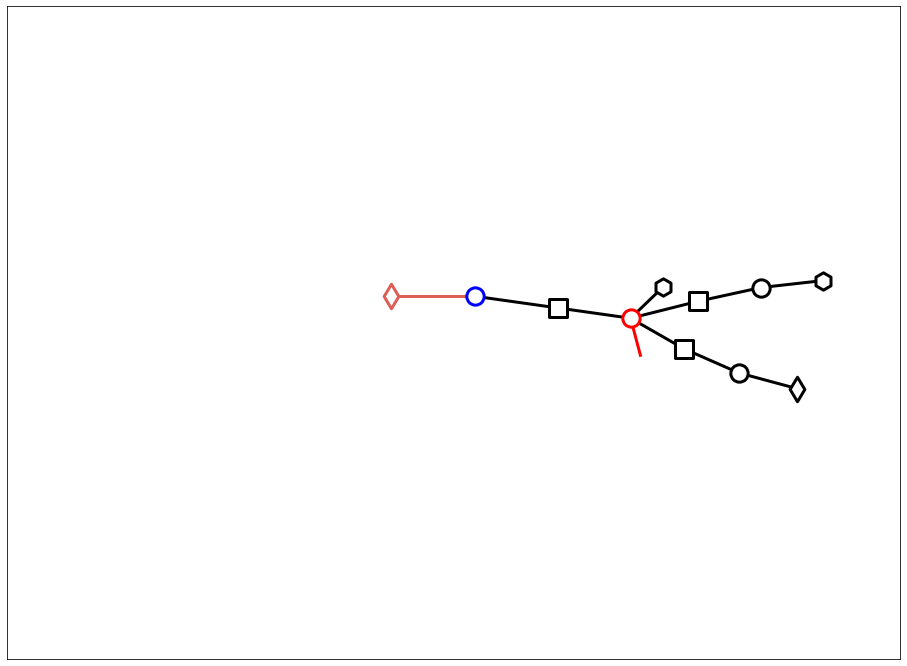

In [10]:
i = 142
a = 241
pause_time = 2
process_animation_show(G,Ne,a,i,pause_time)

<font size=3>&nbsp; &nbsp;We just repeat the above process for each of the boundary-center pairs until each of the message vectors converges, just as it does in the traditional belief propagation.

In [8]:
T = 2.0
beta = 1/T
n = G.number_of_nodes()
step_limit = 10000
epsilon = 1e-6
difference_max = 100
damping_factor = 0
cavity =  np.ones(shape=(n, n, 2)) 
cavity[:,:,0] *= 0.5
cavity[:,:,1] *= 0.5
for step in range(step_limit):
    for center_node in range(n):
        neighborhood = Nv[center_node]
        for node in neighborhood:
            if node in boundaries[center_node]:
                G_cavity = cavity_subgraph_generator(Ne,node,center_node)
                new_cavity_vector = local_contraction(G_cavity,J,h,cavity,node,beta)
                temp = damping_factor * cavity[node][center_node] + (1 - damping_factor) * new_cavity_vector
                temp /= np.linalg.norm(temp)
                difference = max(abs(abs(temp[0]-cavity[node][center_node][0])), abs(abs(temp[1]-cavity[node][center_node][1])))
                cavity[node][center_node] = temp
            else:
                cavity[node][center_node] = np.array([np.exp(beta*h[node]),np.exp(-beta*h[node])])
                cavity[node][center_node] = cavity[node][center_node]/np.linalg.norm(cavity[node][center_node])
                difference = 0
            if center_node == 0 and node == neighborhood[0]:
                difference_max = difference
            elif difference > difference_max:
                difference_max = difference
    print("iteration step:",step+1,",  difference:",difference_max.item())
    if difference_max <= epsilon :
        break
print("iteration finish")


iteration step: 1 ,  difference: 0.33954349988792776
iteration step: 2 ,  difference: 0.17674002059919203
iteration step: 3 ,  difference: 0.07223362816087275
iteration step: 4 ,  difference: 0.043768652596335555
iteration step: 5 ,  difference: 0.020268464698422473
iteration step: 6 ,  difference: 0.006061805427301614
iteration step: 7 ,  difference: 0.0020086007415488494
iteration step: 8 ,  difference: 0.001934967880373284
iteration step: 9 ,  difference: 0.0009374394348171666
iteration step: 10 ,  difference: 0.00016512158793513532
iteration step: 11 ,  difference: 7.017460981084689e-05
iteration step: 12 ,  difference: 3.784823157404471e-05
iteration step: 13 ,  difference: 9.662906830909535e-06
iteration step: 14 ,  difference: 4.372090595228251e-06
iteration step: 15 ,  difference: 2.113435547124176e-06
iteration step: 16 ,  difference: 8.020198865033024e-07
iteration finish


<font size=3>Now with the converged message vectors, we can contract the $\mathcal{N}_i$ to calculate the marginal of each vertex $i$:

In [9]:
marginals = np.zeros(shape=[2,n])
for node in list(G.nodes()):
    G_neighborhood = nx.Graph()
    G_neighborhood.add_edges_from(Ne[node])
    marginal_vector = local_contraction(G_neighborhood,J,h,cavity,node,beta)
    marginals[:,node] = marginal_vector
data_exact = np.loadtxt(open("constants/494bus_random_exact.csv","rb"),delimiter=",")
marginals_exact = np.zeros(shape=[2,n])
for row_id in range(494):
    row = data_exact[row_id]
    marginals_exact[0,row_id] = row[0]
    marginals_exact[1,row_id] = row[1]
error = (np.sum((marginals[0] - marginals_exact[0])**2))**0.5/494
print("The error of TNMP with the exact result is:",error.item())

The error of TNMP with the exact result is: 2.265529418960076e-05
